In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import numpy
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from keras.models import Sequential
from keras.layers import Flatten, Dense,Dropout
from keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomTranslation



2024-12-18 22:05:24.026046: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-18 22:05:24.180000: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 22:05:24.781367: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/yaser/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64::/home/yaser/miniconda3/envs/tf/lib/:/home/yaser/miniconda3/envs/tf/lib/
2024-12-18 22:05:24.782074: W tensorflow/stream_executor/platfor

In [2]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    "./MaskClassification/Training",
    validation_split=0.2,  # Reserve 20% for validation
    subset="training",
    seed=512,
    image_size=(224, 224),
    batch_size=64,
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    "./MaskClassification/Training",
    validation_split=0.2,
    subset="validation",
    seed=512,
    image_size=(224, 224),
    batch_size=64,
)

testing_dataset = tf.keras.utils.image_dataset_from_directory(
    "./MaskClassification/Testing",
    seed=512,
    image_size=(224, 224),
    batch_size=64,
)



Found 1912 files belonging to 2 classes.
Using 1530 files for training.


2024-12-18 22:05:30.017682: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-18 22:05:30.027327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-18 22:05:30.027391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-18 22:05:30.028920: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Found 1912 files belonging to 2 classes.
Using 382 files for validation.
Found 476 files belonging to 2 classes.


In [3]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model, Sequential

AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = preprocess_input(image)  # Preprocess for MobileNet
    return image, label
    

train_dataset = train_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
testing_dataset = testing_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)


train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
testing_dataset = testing_dataset.prefetch(buffer_size=AUTOTUNE)
# Load MobileNet model with pretrained weights, excluding the top (fully connected) layers
mobilenet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# Freeze the layers of MobileNet to retain the pre-trained weights
for layer in mobilenet_model.layers:
    layer.trainable = False

# Define the input
input_tensor = Input(shape=(224, 224, 3))

# Get the output of the MobileNet model
mobilenet_output = mobilenet_model(input_tensor)

# Flatten the output
flattened_output = Flatten()(mobilenet_output)

# Add new layers
dense1 = Dense(50, activation='relu')(flattened_output)
dropout1 = Dropout(0.4)(dense1)
dense2 = Dense(24, activation='sigmoid')(dropout1)
dropout2 = Dropout(0.3)(dense2)
output_tensor = Dense(1, activation='sigmoid')(dropout2)

# Create the model
model = Model(inputs=input_tensor, outputs=output_tensor)

# Model summary
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 50)                2508850   
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 24)                1224      
                                                             

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Metric to monitor
    patience=3,            # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore the weights of the best model
)

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = ['accuracy']
    
)

history = model.fit(train_dataset, validation_data=validation_dataset, batch_size= 64, epochs =7 ,callbacks=[early_stopping])

Epoch 1/7


2024-12-18 22:05:38.505145: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-12-18 22:05:39.301202: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-18 22:05:39.335339: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-18 22:05:39.335403: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-12-18 22:05:39.366826: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-18 22:05:39.366954: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


24/24 [==============================] - 9s 174ms/step - loss: 0.4851 - accuracy: 0.7660 - val_loss: 0.2026 - val_accuracy: 0.9634
Epoch 2/7
24/24 [==============================] - 3s 116ms/step - loss: 0.2740 - accuracy: 0.9379 - val_loss: 0.1423 - val_accuracy: 0.9791
Epoch 3/7
24/24 [==============================] - 4s 122ms/step - loss: 0.2127 - accuracy: 0.9608 - val_loss: 0.1098 - val_accuracy: 0.9843
Epoch 4/7
24/24 [==============================] - 4s 120ms/step - loss: 0.1676 - accuracy: 0.9719 - val_loss: 0.1015 - val_accuracy: 0.9817
Epoch 5/7
24/24 [==============================] - 4s 121ms/step - loss: 0.1383 - accuracy: 0.9791 - val_loss: 0.0888 - val_accuracy: 0.9843
Epoch 6/7
24/24 [==============================] - 6s 227ms/step - loss: 0.1067 - accuracy: 0.9895 - val_loss: 0.0766 - val_accuracy: 0.9817
Epoch 7/7
24/24 [==============================] - 4s 122ms/step - loss: 0.0995 - accuracy: 0.9856 - val_loss: 0.0715 - val_accuracy: 0.9817


In [6]:
def undo_preprocess(image):
    return ((image + 1) * 127.5)


1/1 [==============================] - 1s 697ms/step
Testing Accuracy: 96.85%


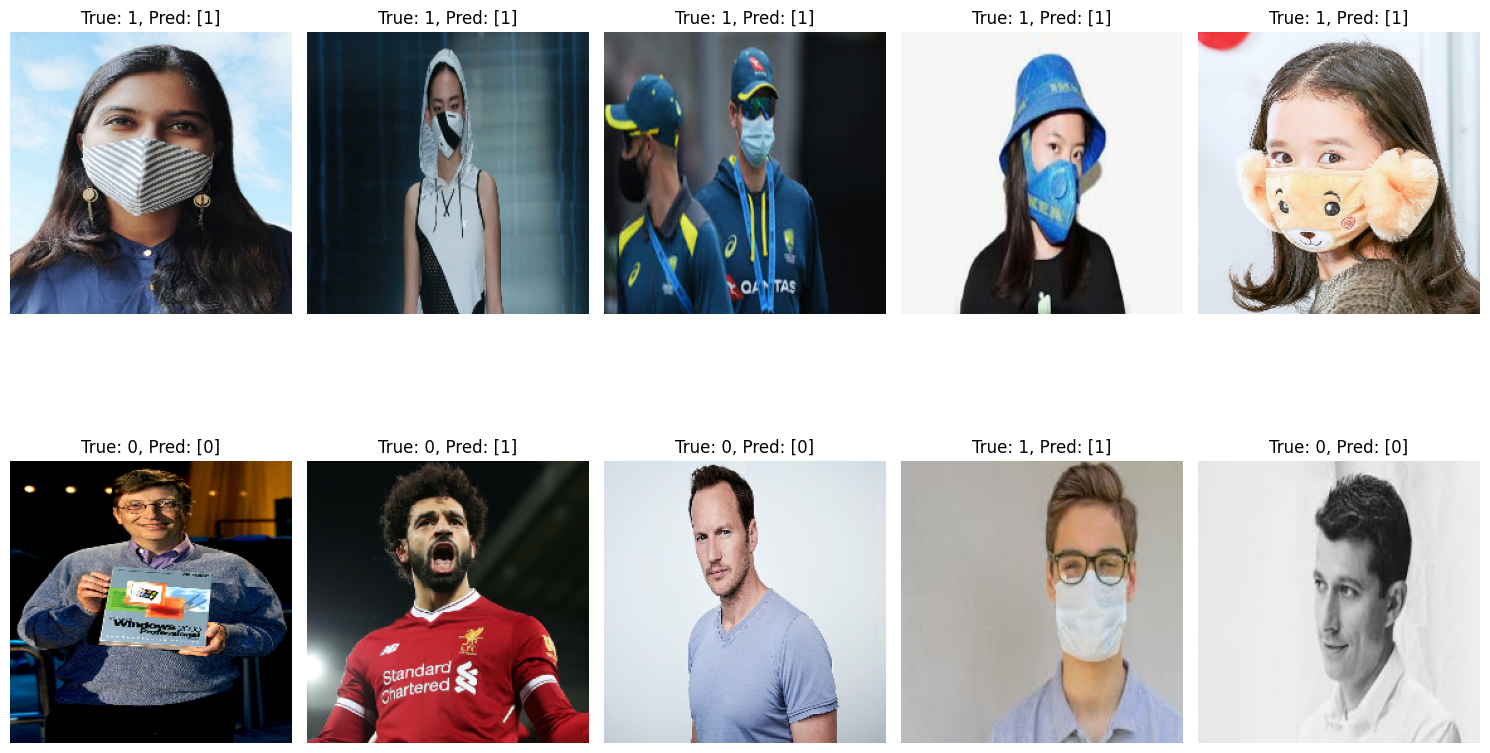

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Initialize lists to store true labels, predicted labels, and images
true_labels = []
predicted_labels = []
images_batch = []

# Iterate through the testing dataset to collect the first 10 images
for images, labels in testing_dataset:
    # Append the images, true labels
    true_labels.append(labels.numpy())
    images_batch.append(images.numpy())
    
    # Get the model predictions (probabilities)
    predicted_probs = model.predict(images)
    
    # Convert the probabilities to predicted labels (0 or 1)
    predicted_labels_batch = (predicted_probs > 0.5).astype(int)
    predicted_labels.append(predicted_labels_batch)
    

# Flatten the lists of true labels, predicted labels, and images
true_labels = np.concatenate(true_labels, axis=0)
predicted_labels = np.concatenate(predicted_labels, axis=0)
images_batch = np.concatenate(images_batch, axis=0)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Testing Accuracy: {accuracy * 100:.2f}%")
# Show the first 10 images with their true and predicted labels
plt.figure(figsize=(15, 10))

for i in range(10):
    plt.subplot(2, 5, i + 1)  # Arrange images in 2 rows and 5 columns
    rgb_image = undo_preprocess(images_batch[i])
    plt.imshow(rgb_image.astype(np.uint8))  # Display the image as uint8
    plt.title(f"True: {true_labels[i]}, Pred: {predicted_labels[i]}")
    plt.axis('off')  # Hide axes

plt.tight_layout()
plt.show()


In [8]:
from sklearn.metrics import classification_report, confusion_matrix
# Classification Report: Precision, Recall, F1-Score
report = classification_report(true_labels, predicted_labels, target_names=["No Mask", "Mask"])
print("Classification Report:")
print(report)




Classification Report:
              precision    recall  f1-score   support

     No Mask       0.97      0.97      0.97       238
        Mask       0.97      0.97      0.97       238

    accuracy                           0.97       476
   macro avg       0.97      0.97      0.97       476
weighted avg       0.97      0.97      0.97       476



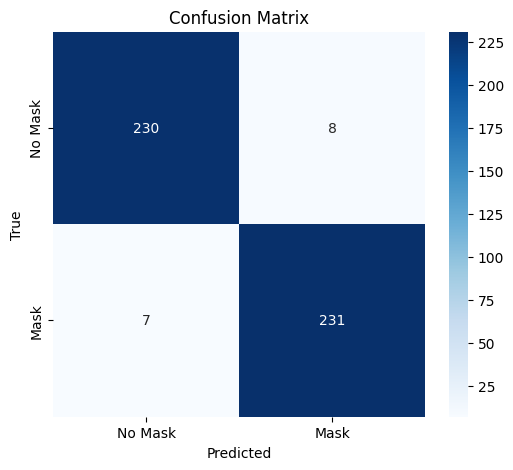

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Mask", "Mask"], yticklabels=["No Mask", "Mask"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [10]:
model.save("MaskClassification-MobileNet.keras")

In [11]:
import pickle
# Save the history to a file
with open('MaskClassification-MobileNet.pkl', 'wb') as file:
    pickle.dump(history, file)

INFO:tensorflow:Assets written to: ram://850ba7bd-bed5-4830-8fd5-2a5f1837fe07/assets


INFO:tensorflow:Assets written to: ram://850ba7bd-bed5-4830-8fd5-2a5f1837fe07/assets


In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model
model = load_model("MaskClassification-MobileNet.keras")

2024-12-19 00:00:11.618215: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-19 00:00:12.232531: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 00:00:13.427812: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/yaser/miniconda3/envs/tf/lib/:/home/yaser/miniconda3/envs/tf/lib/
2024-12-19 00:00:13.428534: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plug

In [6]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
